In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import numpy as np

import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

<IPython.core.display.Javascript object>

In [3]:
min_records = 32  # base 2 makes it look less arbitrary
emotions = ["angry", "scared", "happy", "sad", "surprised", "neutral"]

# 'mf' = 'music_face'
mf = pd.read_csv("data/joined_data.csv")
mf["song_id"] = mf["track_name"] + " - " + mf["artist_name"]

# drop songs that don't meet min record req
song_counts = mf["song_id"].value_counts()
song_counts = song_counts[song_counts > min_records]
mf = mf[mf["song_id"].isin(song_counts.index)]

mf["top_emotion"] = mf[emotions].idxmax(axis=1)

print(f"mf.shape: {mf.shape}")
mf.head(3)

mf.shape: (8980, 14)


,timestamp,angry,scared,happy,sad,surprised,neutral,end_time,artist_name,track_name,time_played,start_time,song_id,top_emotion
0,2019-12-19 11:25:38+00:00,0.069113,0.109064,0.000982,0.557766,0.001962,0.261114,2019-12-19 11:27:00+00:00,Underground Springhouse,Joyfell,0 days 00:01:26.520000000,2019-12-19 11:25:33.480000+00:00,Joyfell - Underground Springhouse,sad
1,2019-12-19 11:25:53+00:00,0.024520,0.151708,0.001428,0.775339,0.001056,0.045949,2019-12-19 11:27:00+00:00,Underground Springhouse,Joyfell,0 days 00:01:26.520000000,2019-12-19 11:25:33.480000+00:00,Joyfell - Underground Springhouse,sad
2,2019-12-19 11:26:08+00:00,0.076808,0.146932,0.000880,0.598738,0.002113,0.174530,2019-12-19 11:27:00+00:00,Underground Springhouse,Joyfell,0 days 00:01:26.520000000,2019-12-19 11:25:33.480000+00:00,Joyfell - Underground Springhouse,sad


<IPython.core.display.Javascript object>

In [4]:
mf["top_emotion"].value_counts()

sad          5567
neutral      3065
angry         217
happy          71
scared         43
surprised      17
Name: top_emotion, dtype: int64

<IPython.core.display.Javascript object>

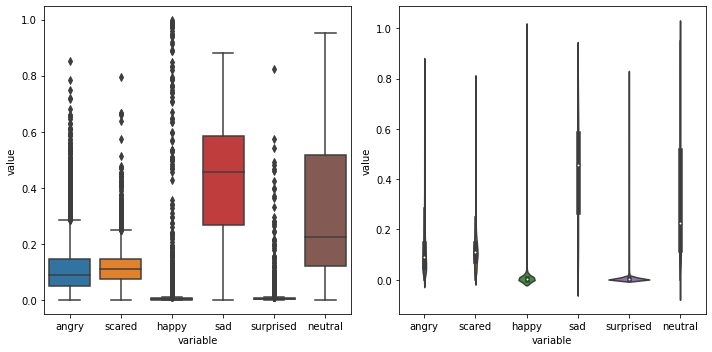

<IPython.core.display.Javascript object>

In [5]:
plot_df = mf[emotions]
plot_df = plot_df.melt()

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.boxplot("variable", "value", data=plot_df, ax=axes[0])
sns.violinplot("variable", "value", data=plot_df, ax=axes[1])
plt.tight_layout()
plt.show()

In [6]:
def std_scale(x):
    return (x - np.mean(x)) / np.std(x)


mf[emotions] = mf[emotions].apply(std_scale)

<IPython.core.display.Javascript object>

In [7]:
aggs = {e: "mean" for e in emotions}
aggs["end_time"] = "count"


mean_song_emotion = mf.groupby("song_id").agg(aggs)
mean_song_emotion = mean_song_emotion.rename(columns={"end_time": "n_samples"})

top_emotion_dfs = {}
for e in emotions:
    print(f"\nTop songs for {e}")

    # fmt: off
    top_emotion_df = (
        mean_song_emotion
         .sort_values(e, ascending=False)
         .head()
         .reset_index()
    )
    # fmt: on

    top_emotion_dfs[e] = top_emotion_df
    display(top_emotion_df.style.background_gradient())


Top songs for angry


,song_id,angry,scared,happy,sad,surprised,neutral,n_samples
0,Syncopated Healing - Twiddle,1.513435,-0.141945,0.215107,-0.469993,-0.080914,-0.197877,37
1,Love Generator - Big Something,0.840347,0.032335,-0.129291,0.089517,0.152088,-0.362617,51
2,Electric Feel - Coast Modern,0.763808,0.460014,-0.160410,0.237527,-0.061205,-0.525108,36
3,Wasted - Rainbow Kitten Surprise,0.637102,-0.013560,-0.093435,-0.425757,-0.043047,0.135803,52
4,Pretty Dirty (In the Fading Light) - Ripe,0.633409,0.489593,-0.068211,0.022050,0.367566,-0.379444,39



Top songs for scared


,song_id,angry,scared,happy,sad,surprised,neutral,n_samples
0,I Got Loaded - The Wood Brothers,-0.054571,0.709579,-0.161466,0.778514,-0.158181,-0.703371,44
1,"I Know You Rider - Live at Portland Memorial Coliseum, Portland, OR 5/19/74 - Grateful Dead",0.110470,0.634938,0.011599,0.510295,-0.088770,-0.587922,34
2,gray - slenderbodies,0.088191,0.574081,0.269553,0.511683,-0.149702,-0.630876,34
3,Baseball - Michigan Rattlers,-0.092161,0.561423,-0.161437,0.957227,-0.172096,-0.793772,38
4,Working Man - The Dip,0.098165,0.518341,0.331947,0.397100,-0.063670,-0.555885,61



Top songs for happy


,song_id,angry,scared,happy,sad,surprised,neutral,n_samples
0,Electric Taco Stand - Spafford,-0.220693,-0.231353,2.112287,-0.440345,0.256254,-0.115087,62
1,Midnight Lorry - Dispatch,-0.352691,0.128743,0.820233,-0.298894,-0.102189,0.119473,45
2,Opening Act (The Shooby Dooby Song) - Bahamas,0.044331,0.176872,0.594363,0.363390,-0.117730,-0.494768,39
3,Entrance - Vacationer,0.026865,0.247728,0.589985,-0.112865,-0.079471,-0.132861,37
4,Come as Your Kids - Umphrey's McGee,0.531025,0.084128,0.533157,-0.116009,-0.081543,-0.259194,46



Top songs for sad


,song_id,angry,scared,happy,sad,surprised,neutral,n_samples
0,Baseball - Michigan Rattlers,-0.092161,0.561423,-0.161437,0.957227,-0.172096,-0.793772,38
1,Why Did You Run? - Judah & the Lion,-0.400556,0.062910,0.207971,0.859801,-0.167757,-0.586924,36
2,Letter for God - Abhi The Nomad,0.361638,0.147154,-0.154344,0.844424,-0.166384,-0.773881,47
3,I Got Loaded - The Wood Brothers,-0.054571,0.709579,-0.161466,0.778514,-0.158181,-0.703371,44
4,drugs - EDEN,0.169700,0.380199,-0.154967,0.762882,-0.160967,-0.695724,48



Top songs for surprised


,song_id,angry,scared,happy,sad,surprised,neutral,n_samples
0,In Green (feat. Sarah Quintana) - Generationals,-0.199671,-0.251665,-0.070668,-0.342217,0.668559,0.359830,36
1,Trouble - Grapetooth,-0.467191,0.007898,0.010696,-0.156586,0.462196,0.246061,76
2,Cosmic Cowboy - Susto,-0.364601,-0.050025,-0.026893,-0.291895,0.416255,0.343415,64
3,Pretty Dirty (In the Fading Light) - Ripe,0.633409,0.489593,-0.068211,0.022050,0.367566,-0.379444,39
4,The Kids - Sol,-0.332477,0.089904,-0.002437,-0.056554,0.358206,0.111906,95



Top songs for neutral


,song_id,angry,scared,happy,sad,surprised,neutral,n_samples
0,Friction - Kai Straw,-0.835186,-0.931140,-0.037062,-1.236009,-0.033453,1.511181,41
1,Only Yesterday - Pretty Lights,-0.231886,-0.754427,-0.068537,-1.082881,-0.025295,1.136971,47
2,Sunny Rain DayMoon - Eldren,-0.685606,-0.583519,-0.045018,-0.763550,-0.030616,1.004146,35
3,Bikes - Rubblebucket,0.125716,-0.612775,-0.059775,-1.094847,-0.002189,0.978089,34
4,Sometimes - Ghostland Observatory,-0.593095,-0.440490,-0.043490,-0.810848,-0.006919,0.971072,46


<IPython.core.display.Javascript object>

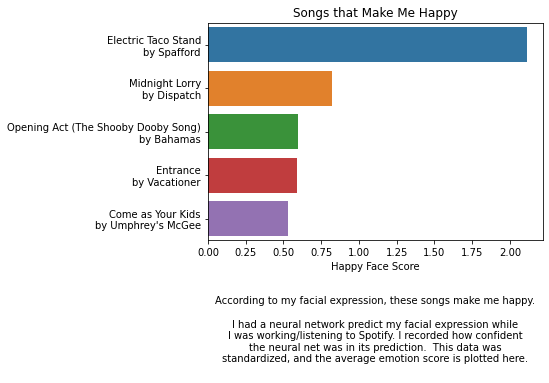

<IPython.core.display.Javascript object>

In [8]:
top_happy = top_emotion_dfs["happy"]
top_happy["song_id"] = top_happy["song_id"].str.replace(" - ", "\nby ", regex=False)
sns.barplot(x="happy", y="song_id", data=top_happy)
plt.ylabel("")
plt.xlabel(
    "Happy Face Score\n\n\n"
    "According to my facial expression, these songs make me happy.\n\n"
    "I had a neural network predict my facial expression while\n"
    "I was working/listening to Spotify. I recorded how confident\n"
    "the neural net was in its prediction.  This data was\n"
    "standardized, and the average emotion score is plotted here.\n"
)
plt.title("Songs that Make Me Happy")
plt.show()

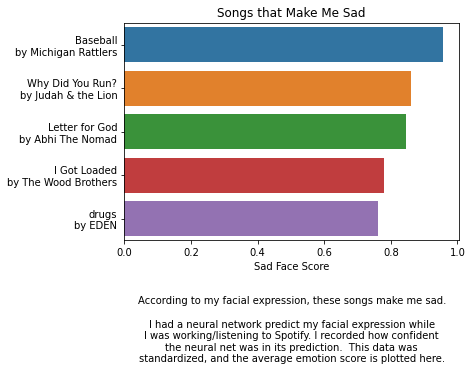

<IPython.core.display.Javascript object>

In [9]:
top_happy = top_emotion_dfs["sad"]
top_happy["song_id"] = top_happy["song_id"].str.replace(" - ", "\nby ", regex=False)
sns.barplot(x="sad", y="song_id", data=top_happy)
plt.ylabel("")
plt.xlabel(
    "Sad Face Score\n\n\n"
    "According to my facial expression, these songs make me sad.\n\n"
    "I had a neural network predict my facial expression while\n"
    "I was working/listening to Spotify. I recorded how confident\n"
    "the neural net was in its prediction.  This data was\n"
    "standardized, and the average emotion score is plotted here.\n"
)
plt.title("Songs that Make Me Sad")
plt.show()